# MASTER - Notebook 2
### Matteo Grazioso 884055

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

import myfunctions as mf # Custom functions

In [2]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# The file contains the data of the validation of tickets in the city of public transport of Venice.
# The file has been created by the Notebook 1.ipynb

# Import the data into a dataframe of a txt file
path = 'data/processed/dataset_cleaned_validazioni.txt'
# path = 'data/processed/dataset_cleaned_esportazioneCompleta.txt'

df = pd.read_csv(path, header=0, sep='\t')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('_')[-1].split('.')[0]

# Display the first 5 rows of the dataframe
df.head()

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

In [4]:
# Create a partition of 10% of the dataframe
df = df.sample(frac=0.1, random_state=1)

In [5]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
557994,2022-05-22,10:07:00,2022-05-22 10:07:00,36141601419748868,6027,MESTRE CENTR,11261,1,DAILY PASS VENEZIA - AVM
3332130,2022-06-29,16:24:00,2022-06-29 16:24:00,40549429059008004,162,STAZIONE MES,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC
2675168,2022-06-20,09:27:00,2022-06-20 09:27:00,40549743250560260,7777,PEOPLE MOVER,11151,7,PEOPLEMOVER+BUS+TRAM 75'
3859966,2022-07-07,13:19:00,2022-07-07 13:19:00,40551472784538116,5113,BURANO,11261,1,DAILY PASS VENEZIA - AVM
2508627,2022-06-17,22:39:00,2022-06-17 22:39:00,37273064648493060,5009,SAN MARCO,11138,7,"75'-TPL 13,28-COMVE1,72"


In [6]:
df.tail()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
4320183,2022-07-13,15:03:00,2022-07-13 15:03:00,40551471443186180,5096,MURANO,11261,1,DAILY PASS VENEZIA - AVM
687741,2022-05-23,21:24:00,2022-05-23 21:24:00,36144856607953156,5031,P.LE ROMA,11101,7,"75'-TPL 6,64-COMVE0,86"
3273433,2022-06-28,17:47:00,2022-06-28 17:47:00,37554740548798724,5053,SAN MARCO,11230,3,72 ORE R.VENICE+AEROPORTO CS
2249389,2022-06-14,16:13:00,2022-06-14 16:13:00,65676356087740933,5191,FERROVIA,11101,7,"75'-TPL 6,64-COMVE0,86"
4053494,2022-07-09,22:10:00,2022-07-09 22:10:00,40551472785455364,7777,PEOPLE MOVER,11151,7,PEOPLEMOVER+BUS+TRAM 75'


---------


## Trajectories

We are interested in analyzing the trajectories of the users that use the public transport in the city of Venice.

Note that the stops are identified by the *DESCRIZIONE* column that contains the name of the stop, so each trajectory 
is composed by the name of the stops visited by the user, so a trajectory is composed by a sequence of strings.

In [7]:
def create_dictionary_with_trajectories(df: pd.DataFrame) -> dict:
    """
        This function creates a dictionary with the trajectories of the users.
        :param df: the dataframe
        :return: the dictionary with the trajectories of the users
    """
    # Create a dictionary with the trajectories of the users
    dict_trajectories = {}
    # For each user
    for serial in df['SERIALE'].unique():
        # Select only the rows of the specified user
        df_sup = df[df['SERIALE'] == serial]
        # If the dataframe is not empty, focus on the user
        if df_sup.shape[0] != 0:
            # Create a list with the name of the stops visited by the user
            list_stops = df_sup['DESCRIZIONE'].unique().tolist()
            # Add the list to the dictionary
            dict_trajectories[serial] = list_stops

    return dict_trajectories

In [8]:
def average_length_of_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '') -> float:
    """
        This function computes the average length of the trajectories.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :return: the average length of the trajectories
    """
    # Compute the average length of the trajectories
    average_length = 0
    for serial in dict_trajectories.keys():
        average_length += len(dict_trajectories[serial])
    if len(dict_trajectories.keys()) != 0:
        average_length /= len(dict_trajectories.keys())
        if is_focus_on_ticket_code:
            print('The average length of the trajectories with the ticket code {} is: {}'.format(ticket_code, average_length))
        else:
            print('The average length of the trajectories is: {}'.format(average_length))
    else:
        print('WARNING: There are no trajectories to analyze')

    return average_length

In [9]:
def average_lenght_of_trajectories_per_ticket_code_stmp(df: pd.DataFrame):
    """
        This function computes the average length of the trajectories for each ticket code in the dataset.
        The order of the ticket codes is mantained because the ticket codes are stored in the dictionary "dict_ticket_codes.json".
        :param df: the dataframe
        :return: None
    """
    dict_trajectories = {}
    dict_ticket_codes = mf.open_dict_ticket_codes()

    # For each ticket code in the dictionary
    for ticket_code in dict_ticket_codes.keys():
        # Select only the rows of the specified ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        
        # If the dataframe is not empty, focus on the ticket code
        if df_sup.shape[0] != 0:
            # Create a dictionary with the trajectories of the users
            dict_trajectories[ticket_code] = create_dictionary_with_trajectories(df_sup)
            average_length_of_trajectories(dict_trajectories[ticket_code], is_focus_on_ticket_code=True, ticket_code=ticket_code)
        else:
            # If the dataframe is empty, skip the ticket code but launch a warning
            print('WARNING: There are no validations of the ticket code "{}"'.format(ticket_code))

In [10]:
def average_length_of_trajectories_by_ticket_code_plot(dict_trajectories: dict, df: pd.DataFrame, dictionary: str) -> None:
    """
        This function computes the average length of the trajectories by ticket code.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param df: the dataframe
        :param dictionary: the path of the dictionary with the ticket codes and their description
        :return: None
    """
    # Compute the average length of the trajectories:
            # There are no colums with the coordinates of the stations, and there are no columns with the distance between the stations
            # So, I compute the average length of the trajectories by the number of stations visited
    
    # Open the dictionary
    dict_ticket_code = mf.open_dict_ticket_codes()

    # Create a dictionary with the number of stations visited for each ticket code
    dict_number_of_stations = {}
    for ticket_code in dict_ticket_code.keys():
        # Select only the rows of the specified ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        # If the dataframe is not empty, focus on the ticket code
        if df_sup.shape[0] != 0:
            # Count the number of stations visited
            number_of_stations = 0
            for serial in df_sup['SERIALE'].unique():
                number_of_stations += len(dict_trajectories[serial])
            # Add the average length of the trajectories to the dictionary
            dict_number_of_stations[ticket_code] = number_of_stations / df_sup['SERIALE'].nunique() 

    # Plot the average length of the trajectories by ticket code
    plt.figure(figsize=(20, 10))
    plt.bar(dict_number_of_stations.keys(), dict_number_of_stations.values())
    plt.title('Average length of the trajectories by ticket code')
    plt.xlabel('Ticket code')   
    plt.ylabel('Average length of the trajectories')

    # Manage the x-axis adding the description of the ticket code; note that it is possible that some ticket codes are not present in the plot
    plt.xticks(ticks=range(0, len(dict_number_of_stations.keys())), labels=[dict_ticket_code[ticket_code] for ticket_code in dict_number_of_stations.keys()], rotation=45)
    
    # Manage the y-axis: note that the y-axis are float numbers: do not convert them to integers and do not use the range function
    if max(dict_number_of_stations.values()) < 0.1:
        plt.yticks(ticks=np.arange(0, max(dict_number_of_stations.values()) + 0.01, 0.01))
    else:
        plt.yticks(ticks=np.arange(0, max(dict_number_of_stations.values()) + 0.01, 0.5))

    plt.show()

In [11]:
def most_frequent_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = True) -> None:
    """
        This function finds the most frequent trajectories.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: True if the analysis is focused on a specific ticket code, False otherwise
        :param ticket_code: the ticket code
        :param summary: True if the summary of the most frequent trajectories is printed, False otherwise
        :return: None
    """
    # Find the most frequent trajectories
    # Create a dictionary with the number of times that a trajectory is present
    dict_trajectories_number = {}

    # For each user (identified by the serial number)
    for serial in dict_trajectories.keys():
        # Convert the list of tuples in a tuple of tuples
        trajectory = tuple(dict_trajectories[serial])

        if trajectory in dict_trajectories_number.keys():
            # If the trajectory is already present in the dictionary, 
            # increase the number of times that the trajectory is present
            dict_trajectories_number[trajectory] += 1
        else:
            # Otherwise, add the trajectory to the dictionary
            dict_trajectories_number[trajectory] = 1

    # Sort the dictionary by the number of times that a trajectory is present
    dict_trajectories_number = {k: v for k, v in sorted(dict_trajectories_number.items(), key=lambda item: item[1], reverse=True)}

    if (summary):
        # Print the most frequent trajectories
        if is_focus_on_ticket_code:
            print('The most frequent trajectories with the ticket code {} are:'.format(ticket_code))
        else:
            print('The most frequent trajectories are:')
        for trajectory in list(dict_trajectories_number.keys())[:10]:
            print('The trajectory {} is present {} times'.format(trajectory, dict_trajectories_number[trajectory]))
    else:
        # Return the most frequent trajectories and the number of times that they are present, 
        # ordered by the number of times that they are present
        return dict_trajectories_number

In [12]:
def trajectories_with_at_least_k_stations(dict_trajectories: dict, k: int) -> None:
    """
        This function finds the trajectories with at least k stations visited.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param k: the number of stations
        :return: None
    """
    # Find the trajectories with at least k stations visited
    # Create a dictionary with the number of times that a trajectory is present
    dict_trajectories_number = {}
    for serial in dict_trajectories.keys():
        trajectory = tuple(dict_trajectories[serial])
        if trajectory in dict_trajectories_number.keys():
            dict_trajectories_number[trajectory] += 1
        else:
            dict_trajectories_number[trajectory] = 1

    # Sort the dictionary by the number of times that a trajectory is present
    dict_trajectories_number = {k: v for k, v in sorted(dict_trajectories_number.items(), key=lambda item: item[1], reverse=True)}

    # Print the trajectories with at least k stations visited
    print('The trajectories with at least {} stations visited are:'.format(k))
    for trajectory in dict_trajectories_number.keys():
        if len(trajectory) >= k:
            print('The trajectory {} is present {} times'.format(trajectory, dict_trajectories_number[trajectory]))

In [13]:
def longest_common_subsequence(trajectory_1: list, trajectory_2: list) -> list:
    """
        This function finds the Longest Common Subsequence (LCS) between two trajectories.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the LCS
    """
    # Find the LCS
    # Create a matrix with the length of the LCS between two trajectories
    matrix = [[0 for x in range(len(trajectory_2) + 1)] for y in range(len(trajectory_1) + 1)]
    for i in range(1, len(trajectory_1) + 1):
        for j in range(1, len(trajectory_2) + 1):
            if trajectory_1[i - 1] == trajectory_2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1] + 1
            else:
                matrix[i][j] = max(matrix[i - 1][j], matrix[i][j - 1])

    # Find the LCS
    i = len(trajectory_1)
    j = len(trajectory_2)
    lcs = []
    while i > 0 and j > 0:
        if trajectory_1[i - 1] == trajectory_2[j - 1]:
            lcs.append(trajectory_1[i - 1])
            i -= 1
            j -= 1
        elif matrix[i - 1][j] > matrix[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the LCS
    lcs.reverse()

    return lcs

### Compute the average length of the trajectories with the entire dataset


In [14]:
# Create a dictionary with the trajectories of the users
dict_trajectories = create_dictionary_with_trajectories(df)

The average length of the trajectories is: 1.2036898431565306
The average length of the trajectories with the ticket code 1 is: 1.1584284343311713
The average length of the trajectories with the ticket code 2 is: 1.313636460988199
The average length of the trajectories with the ticket code 3 is: 1.427582032154112
The average length of the trajectories with the ticket code 4 is: 1.7453556094035625
The average length of the trajectories with the ticket code 5 is: 1.0
The average length of the trajectories with the ticket code 7 is: 1.0209402798927836


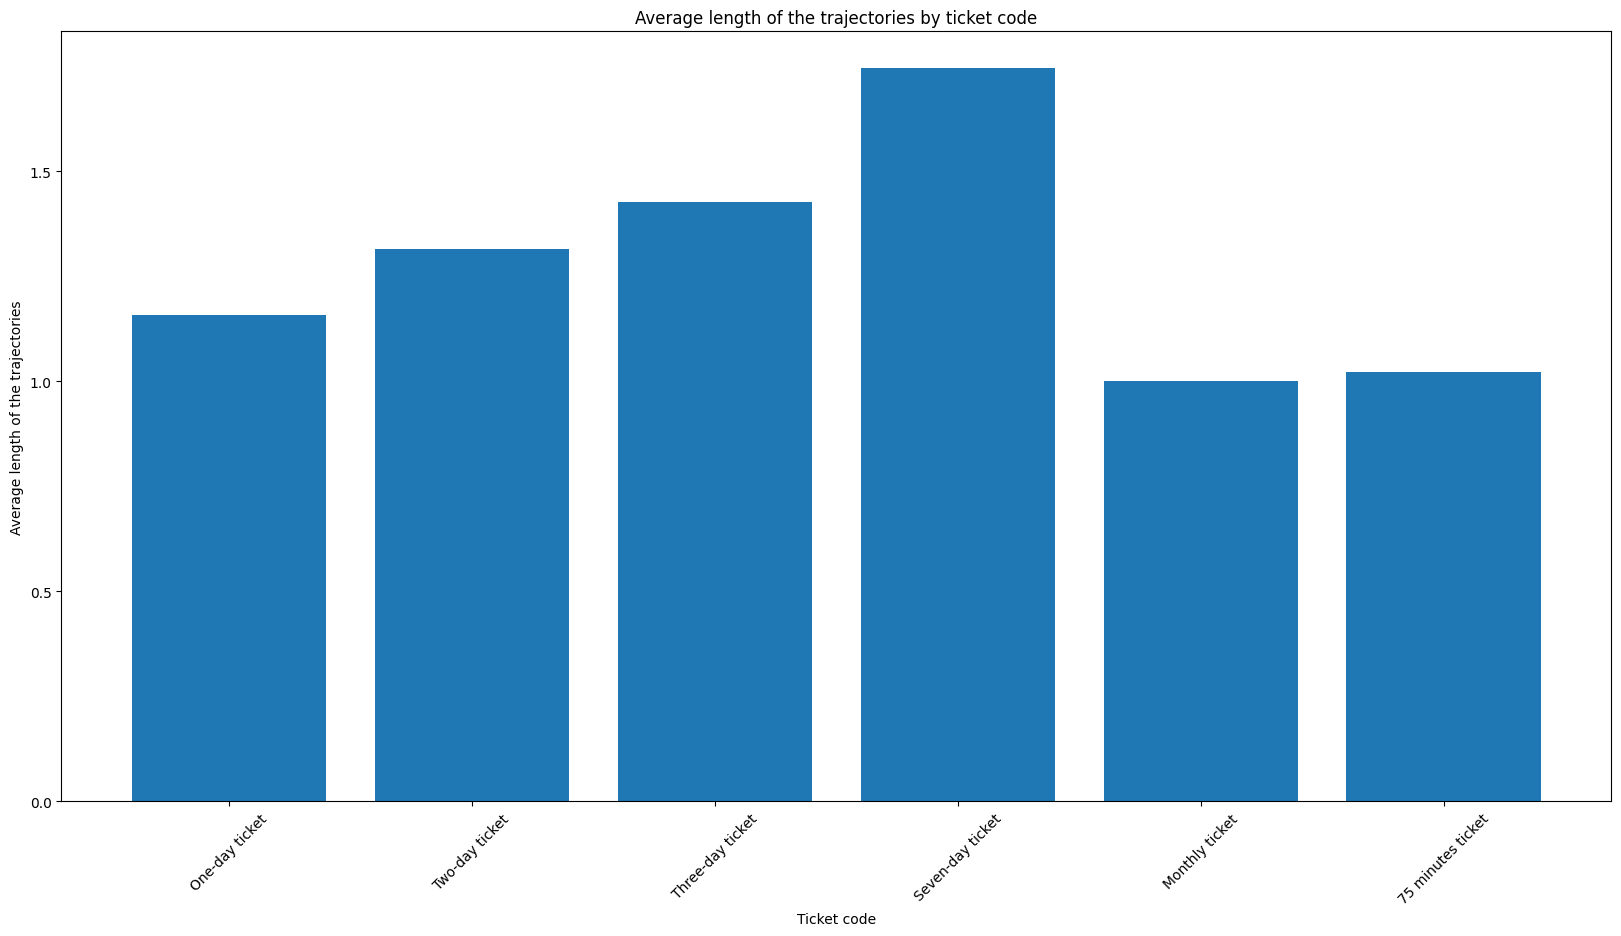

In [15]:
# Compute the average length of the trajectories
average_lenght = average_length_of_trajectories(dict_trajectories)
# Compute the average length of the trajectories by ticket code
average_lenght_of_trajectories_per_ticket_code_stmp(df)
# Plot the average length of the trajectories by ticket code
average_length_of_trajectories_by_ticket_code_plot(dict_trajectories, df, 'data/dictionaries/dict_ticket_codes.json')

### Compute the average length of the trajectories with the dataset with the ticket code 1

In [16]:
# Create a dictionary with the trajectories of the users with the ticket code '2'
df_sup = mf.focus_on_ticket_code(df,'1')
# Create a dictionary with the trajectories of the users
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Compute the average length of the trajectories
average_lenght = average_length_of_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='1')

The average length of the trajectories with the ticket code 1 is: 1.1584284343311713


### Find the most frequent trajectories with the entire dataset

In [17]:
# Create a dictionary with the trajectories of the users with the entire dataset
dict_trajectories = create_dictionary_with_trajectories(df)
# Find the most frequent trajectories and print the summary
most_frequent_trajectories(dict_trajectories, summary=True)

The most frequent trajectories are:
The trajectory ('SAN MARCO',) is present 49828 times
The trajectory ('FERROVIA',) is present 25279 times
The trajectory ('RIALTO',) is present 23231 times
The trajectory ('P.LE ROMA',) is present 23053 times
The trajectory ('BURANO',) is present 18729 times
The trajectory ('VENEZIA',) is present 16681 times
The trajectory ('LIDO',) is present 16435 times
The trajectory ('MURANO',) is present 12077 times
The trajectory ('F.TE NOVE',) is present 10808 times
The trajectory ('PEOPLE MOVER',) is present 9738 times


### Find the most frequent trajectories with the dataset with a specified ticket code

In [18]:
# Create a dictionary with the trajectories of the users with the ticket code '1'
df_sup = mf.focus_on_ticket_code(df,'1')
# Create a dictionary with the trajectories of the users with the ticket code '1'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Find the most frequent trajectories with the ticket code '1' and print the summary
most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='1', summary=True)

The most frequent trajectories with the ticket code 1 are:
The trajectory ('SAN MARCO',) is present 13302 times
The trajectory ('BURANO',) is present 8678 times
The trajectory ('FERROVIA',) is present 5988 times
The trajectory ('RIALTO',) is present 5817 times
The trajectory ('P.LE ROMA',) is present 5720 times
The trajectory ('MURANO',) is present 5228 times
The trajectory ('F.TE NOVE',) is present 4745 times
The trajectory ('LIDO',) is present 3602 times
The trajectory ('PUNTA SABBIO',) is present 3054 times
The trajectory ('VENEZIA',) is present 1413 times


### Finds the trajectories with at least k stations visited with the entire dataset

In [19]:
# Create a dictionary with the trajectories of the users with the entire dataset
dict_trajectories = create_dictionary_with_trajectories(df)
# Find the trajectories with at least 6 stations visited
trajectories_with_at_least_k_stations(dict_trajectories, 6)

The trajectories with at least 6 stations visited are:
The trajectory ("SAN TOMA'", 'LIDO', 'SAN MARCO', 'P.LE ROMA', 'BURANO', 'SAN SILVESTR') is present 1 times
The trajectory ('SAN SILVESTR', "CA' D'ORO", 'SAN MARCO', 'GIGLIO', 'BURANO', 'SALUTE') is present 1 times
The trajectory ('SAN MARCO', 'LIDO', 'RIALTO', 'S. MARCUOLA-', 'FERROVIA', 'GIUDECCA PAL') is present 1 times
The trajectory ('ZATTERE', 'GIARDINI', 'ACCADEMIA', 'MURANO', 'LIDO', 'SAN MARCO') is present 1 times
The trajectory ('RIALTO', 'CIMITERO', 'F.TE NOVE', 'LIDO', 'SAN MARCO', 'MURANO') is present 1 times
The trajectory ('BURANO', "CA' REZZONIC", 'GIGLIO', 'MURANO', 'F.TE NOVE', 'GIUDECCA PAL', 'ZATTERE', 'S.ERASMO') is present 1 times
The trajectory ('VENEZIA', 'FERROVIA', 'BURANO', 'P.LE ROMA', 'GALLO', 'MARCONI', 'SAN MARCO') is present 1 times
The trajectory ('SANTA MARIA ', 'GIARDINI', 'CAPOLINEA', 'ANCONA', 'VENEZIA', 'SAN MARCO') is present 1 times
The trajectory ('RIALTO', 'SAN MARCO', 'P.LE ROMA', 'MURANO'

### Find the most frequent trajectories with the dataset with a specified ticket code


In [20]:
# Create a dictionary with the trajectories of the users with the ticket code '1'
df_sup = mf.focus_on_ticket_code(df,'1')
# Create a dictionary with the trajectories of the users with the ticket code '1'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Find the trajectories with at least 20 stations visited with the ticket code '1'
trajectories_with_at_least_k_stations(dict_trajectories, 20)

The trajectories with at least 20 stations visited are:


### Longest Common Subsequence (LCS)

In [21]:
# Find the Longest Common Subsequence (LCS) between two trajectories
trajectory_1 = ['SAN MARCO', 'P.LE ROMA', 'RIALTO', 'PUNTA SABBIO', 'BURANO']
trajectory_2 = ['SAN MARCO', 'P.LE ROMA', 'PUNTA SABBIO', 'BURANO']

lcs = longest_common_subsequence(trajectory_1, trajectory_2)
print('The Longest Common Subsequence (LCS) between the trajectories {} and {} is {}'.format(trajectory_1, trajectory_2, lcs))

The Longest Common Subsequence (LCS) between the trajectories ['SAN MARCO', 'P.LE ROMA', 'RIALTO', 'PUNTA SABBIO', 'BURANO'] and ['SAN MARCO', 'P.LE ROMA', 'PUNTA SABBIO', 'BURANO'] is ['SAN MARCO', 'P.LE ROMA', 'PUNTA SABBIO', 'BURANO']


In [22]:
# Find the Longest Common Subsequence (LCS) between two trajectories
# Trajectory 1 is the trajectory of the dataset with the ticket code 1
# Trajectory 2 is the most frequent trajectory of the dataset with the ticket code 2
df_sup = mf.focus_on_ticket_code(df,'1')
dict_trajectories = create_dictionary_with_trajectories(df_sup)
dict_trajectories_number = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='1', summary=False)
trajectory_1 = list(dict_trajectories_number.keys())[8]

df_sup = mf.focus_on_ticket_code(df,'2')
dict_trajectories = create_dictionary_with_trajectories(df_sup)
dict_trajectories_number = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='2', summary=False)
trajectory_2 = list(dict_trajectories_number.keys())[0]

lcs = longest_common_subsequence(trajectory_1, trajectory_2)
print('The Longest Common Subsequence (LCS) between the trajectory {} and the trajectory {} is {}'.format(trajectory_1, trajectory_2, lcs))

The Longest Common Subsequence (LCS) between the trajectory ('PUNTA SABBIO',) and the trajectory ('SAN MARCO',) is []


_____

In [23]:
def compare_trajectories (trajectory_1: dict, trajectory_2: dict) -> int:
    """
        This function compares two trajectories and returns the number of stations visited in common.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the number of stations visited in common
    """
    # Find the LCS
    lcs = longest_common_subsequence(trajectory_1, trajectory_2)

    # Find the number of stations visited in common
    number_of_stations_visited_in_common = len(lcs)
    
    return number_of_stations_visited_in_common

In [24]:
# Compare the trajectories of the users with the ticket code '1' and '2' 

# Create a dictionary with the trajectories of the users with the ticket code '1'
df_sup = mf.focus_on_ticket_code(df,'1')
dict_trajectories_1 = create_dictionary_with_trajectories(df_sup)

# Create a dictionary with the trajectories of the users with the ticket code '2'
df_sup = mf.focus_on_ticket_code(df,'2')
dict_trajectories_2 = create_dictionary_with_trajectories(df_sup)

# Find the most frequent trajectories with the ticket code '1' and print the summary
most_trj_1 = most_frequent_trajectories(dict_trajectories_1, is_focus_on_ticket_code=True, ticket_code='1', summary=False)

# Find the most frequent trajectories with the ticket code '2' and print the summary
most_trj_2 = most_frequent_trajectories(dict_trajectories_2, is_focus_on_ticket_code=True, ticket_code='2', summary=False)

# Compare the trajectories of the users with the ticket code '1' and '2'
compare_trajectories(most_trj_1, most_trj_2)


KeyError: 0